# Is Software Updated?

This notebook looks at references to GitHub URLs in papers available in the OA corpus from EuroPMC,
and identifies:

  * How many times the GitHub repositories have been updated since paper referencing them was released
  
Note that at present, we are not distinguishing between URLs referencing software *created* by the paper authors,
versus *used* by the authors, nor which software was created as a result of the work in the paper.

In [76]:
import pandas
import json
from datetime import datetime, timedelta
from collections import defaultdict
from github import Github
import numpy as np
import matplotlib.pyplot as plt

import process_eupmc
import process_urls

## File locations

In [2]:
# Directory containing the data
data_dir = '../data'

# File containing the list of matching papers
matching_papers = data_dir + '/' + 'eupmc_fulltext_html_urls.txt'

# File for the output
output_jsonfile = data_dir + '/' + 'dict_of_papers.json'

# Github Token
gh_token = '../secrets/github_token'

In [35]:
with open(gh_token, 'r') as f:
    github_token = f.read().rstrip()

## Use getpapers to download fulltext of papers

We currently do this outside of the notebook, and assume that the files are available locally.

The command we are using is:

>getpapers --query 'github' -x --limit 100 -o data

which queries EuPMC for all papers containing the term 'github' and returns the full text of the first 100 papers matching this into the directory 'data'

## Textmine each paper

In [3]:
# Get the list of subdirectories dumped by ContentMine
paper_ids = process_eupmc.get_pmcids(matching_papers)

In [4]:
# Process the papers and extract all the references to GitHub and Zenodo urls
papers_info = process_eupmc.process_papers(paper_ids, data_dir)

## Analyse GitHub repos to see frequency of commits

In [74]:
g = Github(github_token)
number_of_updates = defaultdict(int)

for p in papers_info:

    repos = []
    # The following removes references to the main github.com site
    # and also treats references to blobs / issues as references to the repo
    for gh_url in p.references['github']:
        words = gh_url.split('/')
        if len(words) > 4: #
            reponame = words[3] + '/' + words[4]
            if reponame not in repos:
                repos.append(reponame)            
    
    for repo in repos:
        print ("Processing: ", repo)
        code = g.get_repo(repo)
        # limit to commits since publication date
        since = datetime.strptime(p.pub_date, '%Y-%m-%d')
        commits = code.get_commits()
        num_commits = 0
        commit_date = commits[num_commits].commit.author.date
        while commit_date > since:
            num_commits = num_commits + 1
            commit_date = commits[num_commits].commit.author.date
        print("Number of commits since publication: ", num_commits)
        number_of_updates[num_commits] +=1

Processing:  theislab/Scanpy
Number of commits since publication:  176
Processing:  theislab/anndata
Number of commits since publication:  57
Processing:  theislab/scanpy_usage
Number of commits since publication:  25
Processing:  linnarsson-lab/loompy
Number of commits since publication:  34
Processing:  PMBio/scLVM
Number of commits since publication:  0
Processing:  YosefLab/FastProject
Number of commits since publication:  0
Processing:  AllonKleinLab/SPRING
Number of commits since publication:  5
Processing:  dimenwarper/scimitar
Number of commits since publication:  0
Processing:  jacoblevine/PhenoGraph
Number of commits since publication:  0
Processing:  asncd/MIMOSCA
Number of commits since publication:  0
Processing:  vals/umis
Number of commits since publication:  0
Processing:  GGiecold/ECLAIR
Number of commits since publication:  0
Processing:  yeolab/flotilla
Number of commits since publication:  0
Processing:  theislab/scanpy
Number of commits since publication:  176
Proc

## Plotting the results

We use a defaultdict so that we can easily zero entries with no data.

In [87]:
most_commits = max(number_of_updates, key=int)

for i in range(most_commits):
    if i not in number_of_updates:
        number_of_updates[i] = 0

In [ ]:
plt.bar(range(len(number_of_updates)), list(number_of_updates.values()), align='center')
plt.suptitle('Does software referenced in publications get updated?')
plt.xlabel('Number of commits since publication date')
plt.ylabel('Number of GitHub repositories')

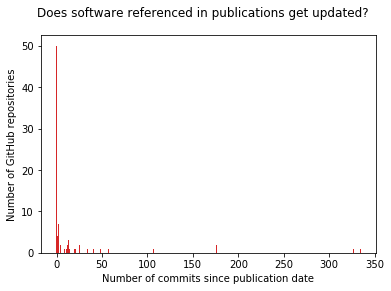

In [97]:
plt.show()

## Caveats to this plot

1. It does not distinguish between software created by the publication author and software referenced by the author
2. It should really be calculating the average number of commits since publication date, not total number of commits